In [1]:
using Distributed
using Distributions
using LinearAlgebra
using Plots
using Test
using Sobol
using Optim
using Profile
using PProf
using Random

In [2]:
if nworkers() < 8
    addprocs(8 - nworkers())
end 

7-element Vector{Int64}:
 2
 3
 4
 5
 6
 7
 8

In [3]:
include("../rollout.jl")
include("../testfns.jl")

TestGramacyLee (generic function with 1 method)

### Psuedo-code for Rollout Bayesian Optimization
1. Generate low-discrepancy sequence for Quasi-Monte Carlo
2. Gather initial samples/experimental data
3. Construct the ground truth surrogate model
4. Setup hyperparameters for stochastic gradient descent
5. While budget has not been exhausted
<ol>
    <li>
        Construct a batch of samples for stochastic gradient descent. For each sample
        <ol>
            <li>Create a copy of the ground truth surrogate at the sample location and the pairwise perturbed surrogate.</li>
            <li style="color: #f66">Initialize our trajectory struct with the fantasized surrogate and fantisized perturbed surrogate and fantasy start location.</li>
            <li>Perform rollout on the trajectory for $r$ steps $M_0$ times for Quasi-Monte Carlo integration.</li>
            <li>Update values for $\alpha$ and $\nabla\alpha$</li>
        </ol>
    </li>
    <li>Once SGD has converged, update sample location using update rule</li>
    <li>Save location and value at location for each sample in batch.</li>
    <li>Select the best sample from the batch and sample original process at new sample location.</li>
    <li>Update surrogate model with value found at new sample location.</li>
    <li>Repeat until budget is exhausted.</li>
</ol>

### Issues
- Use control variates to see how they affect the rollout acquisition functions

#### Probability of Improvement
The probability of improvement (POI) is defined as follows:

$$
POI(x) = \Phi\left( \frac{\mu(x) - f^+ - \xi}{\sigma(x)} \right)
$$

where $f^+$ denotes the best value (maximum) known, $\mu(x)$ is the predictive mean at x, $\sigma(x)$ is the predictive variance, $\xi$ is our exploration parameter, and $\Phi$ is the standard normal cumulative distribution function.
<hr>

#### Expected Improvement
The expected improvement (EI) is defined as follows:

$$
EI(x) = (\mu(x) - f^+ - \xi)\Phi\left( \frac{\mu(x) - f^+ - \xi}{\sigma(x)} \right) +
        \sigma(x)\phi\left(\frac{\mu(x) - f^+ - \xi}{\sigma(x)}\right)
$$

where $\phi$ is the standard normal probability density function.
<hr>

In [4]:
function ei(μ, σ, fbest)
    z = (fbest - μ) / σ
    Φz = Distributions.normcdf(z)
    ϕz = Distributions.normpdf(z)
    return σ*(z*Φz + ϕz)
end

function poi(μ, σ, fbest)
    z = (fbest - μ) / σ
    Φz = Distributions.normcdf(z)
    return Φz
end

poi (generic function with 1 method)

In [5]:
# Global parameters
MAX_SGD_ITERS = 100
BATCH_SIZE = 8
HORIZON = 1
MC_SAMPLES = 10
BUDGET = 1;

### 1. Generate low-discrepancy sequence for Quasi-Monte Carlo

In [6]:
# Setup toy problem
# testfn = TestFunction(
#     1, [0. 1.], [.5],
#     x -> 0. + 1e-6*randn(),
#     ∇x -> [0. + 1e-6*randn()]
# )
testfn = TestAckley(1)
lbs, ubs = testfn.bounds[:,1], testfn.bounds[:,2]

# Setup low discrepancy random number stream
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, HORIZON+1);
rns = randn(MC_SAMPLES, testfn.dim+1, HORIZON+1);

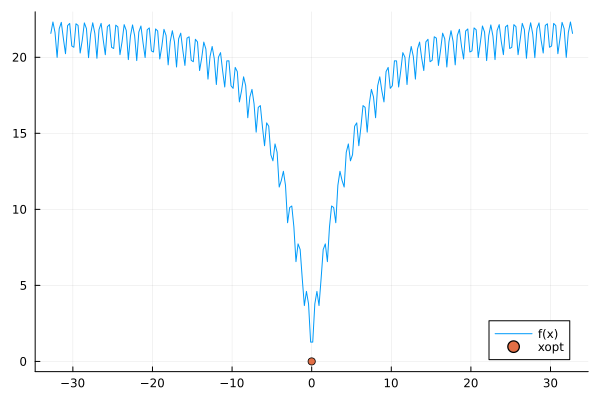

In [7]:
tplot(testfn)

### 2. Gather initial samples/experimental data

In [8]:
# Gather initial samples/experimental data
N, θ = 1, [.25]
# X = [.15, .85]
X = [21.7, -7.2, -17.5, -16.5] .- 6.
# X = collect(-16.:2:16)
X = reshape(X, 1, length(X))
# ψ = kernel_matern52(θ);
ψ = kernel_scale(kernel_matern52, [1., θ...]);

### 3. Construct the ground truth surrogate model

In [9]:
sur = fit_surrogate(ψ, X, testfn.f);
res = optimize_hypers_optim(sur, kernel_matern52)
σ, ℓ = Optim.minimizer(res)
ψ = kernel_scale(kernel_matern52, [σ, ℓ]);
sur = fit_surrogate(ψ, X, testfn.f);

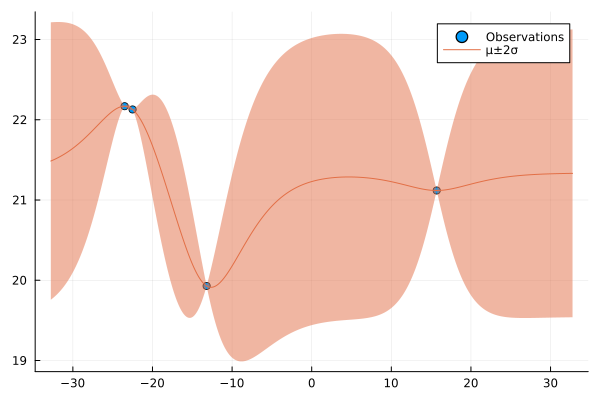

In [10]:
domain = filter(x -> !(x in X), lbs[1]:.01:ubs[1])
plot1D(sur; domain=domain)

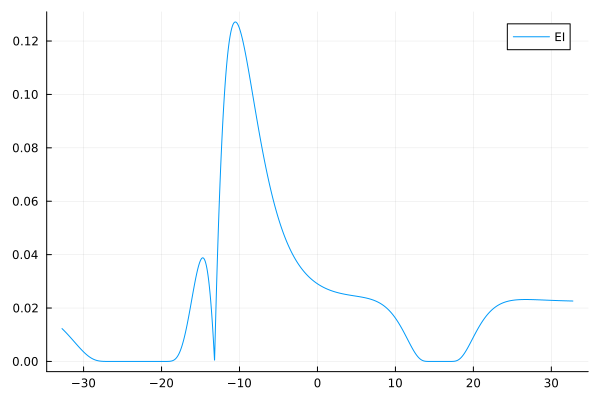

In [11]:
plot1DEI(sur, domain=domain)

### 4. Setup hyperparameters for stochastic gradient descent

In [12]:
# Define the parameters of the optimizer
λ = 0.01  # Learning rate
β1 = 0.9  # First moment decay rate
β2 = 0.999  # Second moment decay rate
ϵ = 1e-8  # Epsilon value

# Define the initial position and moment estimates
m = zeros(testfn.dim)
v = zeros(testfn.dim)

ϵsgd = 1e-12
grad_tol = 1e-5

1.0e-5

### 5. While budget has not been exhausted
Each location in our minibatch is going to be our $x^0$ that serves as our deterministic start location. Then, we perform rollout from that point forward, computing several sample trajectories to then be averaged.

We need a few mechanisms:
* We shouldn't sample at locations that are near known locations in sur.X
* We should perform the evaluations in parallel to save time

In [ ]:
minis = [minimum(sur.y) + sur.ymean]
fbest = testfn.f(testfn.xopt...)

In [ ]:
∇αxs = []
batch = []

final_locations = []

println("Beginning Bayesian Optimization Loop")
for b in 1:BUDGET
    # Generate a batch of evaluation locations and filter out locations that are close
    # to know sample locations
    batch = generate_batch(BATCH_SIZE; lbs=lbs, ubs=ubs)
    # batch = convert(Matrix{Float64}, filter(x -> !(x in sur.X), batch)')
    
    batch_evals = []
    final_locations = []
    
    # This should be a parallel for loop
    println("---------- BO Iteration #$b ----------")
    bndx = 1
    for x0 in eachcol(batch)
        try
            x0 = convert(Vector{Float64}, x0)

            αxs, ∇αxs = [], []
            ∇αxs = [0., 1., 2.]

            print("\n(Batch #$bndx - $x0) Gradient Ascent Iteration Count: ")
            # Run SGD until convergence
            fprev, fnow = 0., 1.
            for epoch in 1:MAX_SGD_ITERS
                if mod(epoch, 25) == 0 print("|") end
                μx, ∇μx = simulate_trajectory(
                    sur; mc_iters=MC_SAMPLES, rnstream=lds_rns, lbs=lbs, ubs=ubs, x0=x0, h=HORIZON
                )

                # Update gradient vector
                push!(αxs, μx)
                push!(∇αxs, first(∇μx))

                fprev = fnow
                fnow = μx

                # Update x0 based on gradient computation
                x0, m, v = update_x_adam(x0; ∇g=-∇μx, λ=λ, β1=β1, β2=β2, ϵ=ϵ, m=m, v=v, lbs=lbs, ubs=ubs)
                # x0 = update_x(x0; λ=λ, ∇g=∇μx, lbs=lbs, ubs=ubs)

                if abs(fnow - fprev) < ϵsgd || norm(∇μx) < grad_tol
                    println("\nConverged after $epoch epochs")
                    # println("abs(fnow - fprev): $(abs(fnow - fprev)) - fnow: $fnow - fprev: $fprev")
                    break
                end

            end

            push!(batch_evals, αxs[end])
            push!(final_locations, x0)
            bndx += 1
        catch e
            bndx += 1
            println(e)
        end
    end
    # Iterate over batch for best response and sample original process afterwards
    if length(batch_evals) > 0
        println()
        [println("α($(pair[1])) = $(pair[2])") for pair in zip(final_locations, batch_evals)]
        ndx = argmax(batch_evals)
        xnew = final_locations[ndx]

        # Sample original process at x0
        println("\nFinal xnew: $xnew")
        println("--------------------------------------\n")
        res = optimize_hypers_optim(sur, kernel_matern52)
        σ, ℓ = Optim.minimizer(res)
        println("Learned Kernel Hyperparameters: σ=$σ -- ℓ=$ℓ")
        ψ = kernel_scale(kernel_matern52, [σ, ℓ]);
        recover_y = sur.y .+ sur.ymean
        sur = fit_surrogate(
            ψ,
            hcat(sur.X, xnew),
            vcat(recover_y, testfn.f(xnew))
        )
        
        push!(minis, minimum(sur.y) + sur.ymean)
    end
end

In [ ]:
domain = filter(x -> !(x in sur.X), lbs[1]:.01:ubs[1])
plot1D(sur; domain=domain)

In [ ]:
init_mini = minis[1]
gap = (init_mini .- minis) / (init_mini - fbest)

In [ ]:
plot(gap)

### Parallel Bayesian Optimization

In [13]:
@everywhere function simulate_trajectory2(sur::RBFsurrogate; x0, mc_iters, rnstream, lbs, ubs, h)
    αxi, ∇αxi = 0., zeros(size(sur.X, 1))

    for sample in 1:mc_iters
        fsur = Base.deepcopy(sur)
        fantasy_ndx = size(fsur.X, 2) + 1

        # Rollout trajectory
        T = Trajectory(fsur, x0, fantasy_ndx; h=h, fopt=minimum(sur.y))
        rollout!(T, lbs, ubs; rnstream=rnstream[sample,:,:])

        # Evaluate rolled out trajectory
        αxi += α(T)
        ∇αxi .+= ∇α(T)
    end

    # Average trajectories MC simulation
    μx = αxi / mc_iters
    ∇μx = ∇αxi / mc_iters

    return μx, ∇μx
end

In [14]:
println("Beginning Bayesian Optimization Loop")
for b in 1:BUDGET
    # Generate a batch of evaluation locations and filter out locations that are close
    # to know sample locations
    # batch = generate_batch(BATCH_SIZE; lbs=lbs, ubs=ubs)
    batch = generate_batch(1; lbs=lbs, ubs=ubs)

    
    # This should be a parallel for loop
    println("---------- BO Iteration #$b ----------")
    batch_results = @distributed for j = 1:size(batch, 2)
        # try
        x0 = batch[:, j]

        αxs, ∇αxs = [], []
        ∇αxs = [0., 1., 2.]

        print("\n(Batch #$j - $x0) Gradient Ascent Iteration Count: ")
        # Run SGD until convergence
        fprev, fnow = 0., 1.
        for epoch in 1:MAX_SGD_ITERS
            if mod(epoch, 25) == 0 print("|") end
            μx, ∇μx = simulate_trajectory2(
                sur; mc_iters=MC_SAMPLES, rnstream=lds_rns, lbs=lbs, ubs=ubs, x0=x0, h=HORIZON
            )

            # Update gradient vector
            push!(αxs, μx)
            push!(∇αxs, first(∇μx))

            fprev = fnow
            fnow = μx

            # Update x0 based on gradient computation
            x0, m, v = update_x_adam(x0; ∇g=-∇μx, λ=λ, β1=β1, β2=β2, ϵ=ϵ, m=m, v=v, lbs=lbs, ubs=ubs)
            # x0 = update_x(x0; λ=λ, ∇g=∇μx, lbs=lbs, ubs=ubs)

            if abs(fnow - fprev) < ϵsgd || norm(∇μx) < grad_tol
                println("\nConverged after $epoch epochs")
                # println("abs(fnow - fprev): $(abs(fnow - fprev)) - fnow: $fnow - fprev: $fprev")
                break
            end

        end

            return (x0, αxs[end])
        # catch e
        #     println(e)
        # end
    end
    
    println(batch_results)
    # batch_results = vcat(batch_results...)
    
#     batch_evals = [br[2] for br in batch_results]
#     final_locations = [br[1] for br in batch_results]
    
#     # Iterate over batch for best response and sample original process afterwards
#     if length(batch_evals) > 0
#         println()
#         [println("α($(pair[1])) = $(pair[2])") for pair in zip(final_locations, batch_evals)]
#         ndx = argmax(batch_evals)
#         xnew = final_locations[ndx]

#         # Sample original process at x0
#         println("\nFinal xnew: $xnew")
#         println("--------------------------------------\n")
#         res = optimize_hypers_optim(sur, kernel_matern52)
#         σ, ℓ = Optim.minimizer(res)
#         println("Learned Kernel Hyperparameters: σ=$σ -- ℓ=$ℓ")
#         ψ = kernel_scale(kernel_matern52, [σ, ℓ]);
#         recover_y = sur.y .+ sur.ymean
#         sur = fit_surrogate(
#             ψ,
#             hcat(sur.X, xnew),
#             vcat(recover_y, testfn.f(xnew))
#         )
        
#         push!(minis, minimum(sur.y) + sur.ymean)
#     end
end

Beginning Bayesian Optimization Loop
---------- BO Iteration #1 ----------
Task (runnable) @0x00007f96b23c9b60
      From worker 2:	


Unhandled Task ERROR: On worker 2:
UndefVarError: rollout! not defined
Stacktrace:
  [1] #simulate_trajectory2#4
    @ ./In[13]:10
  [2] macro expansion
    @ ./In[14]:23 [inlined]
  [3] #591
    @ ~/packages/julias/julia-1.8/share/julia/stdlib/v1.8/Distributed/src/macros.jl:303
  [4] #178
    @ ~/packages/julias/julia-1.8/share/julia/stdlib/v1.8/Distributed/src/macros.jl:83
  [5] #invokelatest#2
    @ ./essentials.jl:729 [inlined]
  [6] invokelatest
    @ ./essentials.jl:726
  [7] #107
    @ ~/packages/julias/julia-1.8/share/julia/stdlib/v1.8/Distributed/src/process_messages.jl:281
  [8] run_work_thunk
    @ ~/packages/julias/julia-1.8/share/julia/stdlib/v1.8/Distributed/src/process_messages.jl:70
  [9] run_work_thunk
    @ ~/packages/julias/julia-1.8/share/julia/stdlib/v1.8/Distributed/src/process_messages.jl:79
 [10] #100
    @ ./task.jl:484
Stacktrace:
 [1] sync_end(c::Channel{Any})
   @ Base ./task.jl:436
 [2] (::Distributed.var"#177#179"{var"#591#592"{Vector{Float64}}, UnitRange{

In [ ]:
# define your custom data structure
struct MyCustomType
    a::Int
    b::Float64
end

# evaluate the definition of your custom type on all worker processes
@everywhere struct MyCustomType
    a::Int
    b::Float64
end